# Video Preprocessing

Description

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json

In [3]:
from video_analyzer import VideoAnalyzer
from preprocessor import Preprocessor

2025-04-04 00:14:36.462712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743693276.517894   38753 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743693276.534698   38753 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 00:14:36.645259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
timestamp = "28032025"
path_to_root = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/"

In [5]:
metadata = pd.read_csv(os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "target_dataset_video_metadata.csv"
    ))

In [6]:
i = 1
metadata_row = metadata.iloc[i].copy()
metadata_row

filename        ajudar_sb_2.mp4
label                    ajudar
data_source                  sb
frame_count                  79
fps                    29.97003
duration_sec           2.635967
width                      1280
height                      720
Name: 1, dtype: object

## Initialize VideoAnalyzer

The VideoAnalyzer has default parameters, but individual parameters can be overridden by passing a params_dict to the constructor.

In [7]:
params = {}
params["motion_start_threshold"] = 0.2
# params["verbose"] =False
params["reuse_results"] = True

You can also override the default parameters by having a column in the metadata_row with the same name as the parameter you want to override.

In [8]:
metadata_row.loc['motion_end_threshold'] = 0.3

The priority order is:
1. params_dict
2. metadata_row
3. default parameters

When you call the constructor, it will tell you which parameters are used and from where.

In [10]:
analyzer = VideoAnalyzer(
    metadata_row,
    timestamp,
    path_to_root,
    params,
    # verbose=False
)

Using parameters from metadata:
	motion_end_threshold = 0.3
Using parameters from params dict:
	motion_start_threshold = 0.2
	reuse_results = True
Using parameters from default values:
	motion_avg_weights = {'basic': 0.3, 'bg_sub': 0.7}
	moving_avg_window_duration = 0.2
	motion_threshold_method = simple
	pose_static_image_mode = False
	pose_model_complexity = 1
	pose_smooth_landmarks = True
	pose_min_detection_confidence = 0.5
	pose_min_tracking_confidence = 0.5
Initialized VideoAnalyzer for ajudar_sb_2.mp4
Video properties: 29.97002997002997 fps, 1280x720, 2.64 seconds


## Motion Detection

`.motion_detect()` will:
- apply all the motion detection methods specified in the code
- save the raw results in /data/interim/RawMotionMeasurements/version{version}/{filename}_{detection_method}.npy
- (or load the already detected raw results to save reprocessing time if reuse_results is True)
- normalize the raw results to a 0-1 scale and combine them as a weighted average
- apply a moving average to the combined results to smooth the data
- return a dictionary with the derived results

In [11]:
motion_data = analyzer.motion_detect()

Loaded motion detection results from versionA
window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size


`.motion_analyze()` will:
- analyze the motion data to find the start and end frames of meaningful motion
- it requires the motion_data to be loaded/created, and some parameters that are used for the method to decide the start and end frames
- it will return a dictionary with the derived start and end frames, and some other related information

In [16]:
motion_result = analyzer.motion_analyze()

Analyzing motion using simple method with thresholds 0.2/0.3
Motion detected from frame 8 to 66 (1.94 seconds)


## Pose Estimation

`.pose_detect()` will:
- apply the MediaPipe Holistic model (with some specified parameters) to the video to detect Face, Pose, and Hand Landmarks
- save the raw results in /data/interim/RawPoseLandmarks/version{version}/{filename}.npy
- (or load the already detected raw results to save reprocessing time if reuse_results is True)
- return a dictionary with the derived results


In [ ]:
pose_data = analyzer.pose_detect()

Loaded pose estimation results from versionA


`.pose_analyze()` will:
- analyze the loaded/created pose data using various methods from `media_pipe_holistic.py`
- currently this includes:
    - horizontal and vertical positions of various key landmarks
    - various measurements between landmarks
- it will return a dictionary with the results


In [20]:
pose_result = analyzer.pose_analyze()

Analyzing pose data...
Pose analysis complete
Horizontal offsets: {'shoulders': {'mean': 0.4949150662633437, 'median': 0.4965493381023407, 'max': 0.5088723599910736, 'min': 0.48143619298934937}, 'face': {'mean': 0.4935306469096413, 'median': 0.49642214179039, 'max': 0.5097975134849548, 'min': 0.47643500566482544}}
Vertical offsets: {'shoulders': {'mean': 0.5217230369018603, 'median': 0.5206832587718964, 'max': 0.5372985899448395, 'min': 0.5068168193101883}, 'face': {'mean': 0.32948389309871046, 'median': 0.3191772401332855, 'max': 0.38651880621910095, 'min': 0.2788856029510498}}
Landmark measurements: {'shoulder_width': {'mean': 0.19643654188049905, 'median': 0.19426915924508475, 'max': 0.2090008389332927, 'min': 0.17850006084790546}, 'hip_width': {'mean': 0.1257517734114194, 'median': 0.12609480072645388, 'max': 0.12865377607265074, 'min': 0.11929909381614845}, 'shoulder_to_hip': {'mean': 0.4793086848003729, 'median': 0.47776501197933896, 'max': 0.49827525282161705, 'min': 0.457183529

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1743690571.202080   30238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743690571.341880   30237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743690571.345903   30240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743690571.346123   30237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743690571.356509   30237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743690571.408025   30

## Save Analysis Info

`.save_analysis_info()` will:
- save all of the analysis info and other metadata to a json file in /data/interim/AnalysisInfo/version{version}/{filename}.json
- it will return a dictionary with the analysis info
- currently this includes:
    - the metadata about the video that was used
    - the parameters used in the detection and analysis
    - the results from the motion detection result analysis
    - the results from the pose detection result analysis


In [22]:
analysis_info = analyzer.save_analysis_info()

Saved analysis info to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Analysis/28032025/individual_json/ajudar_sb_2_analysis_info.json


## Get/Make Preprocessing Params for `preprocessor`

Preprocessor requires:
- start_frame 
- end_frame 
- horizontal_offset 
- x_scale_factor 
- y_scale_factor
- vertical_offset 
- target_duration

In [12]:
path_to_root

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [13]:
analysis_info = json.load(open(os.path.join(path_to_root, "data", "interim", "Analysis", timestamp, "individual_json", metadata_row["filename"].split(".")[0] + "_analysis_info.json")))

### Set Reference Values
- These were decided based on EDA of the full dataset's analysis info in `Analyzed_Videos_EDA.ipynb`.
- They can be changed in future versions if we want to use different reference values to produce different results.

In [14]:
reference_values = {
'face_horizontal_offset': 0.5,
'face_vertical_offset': 0.275,
'face_width': 0.11,
'face_height': 0.23,
'shoulders_horizontal_offset': 0.5,
'shoulders_vertical_offset': 0.52,
'shoulders_width': 0.25,
}

### Start Frame / End Frame

In [15]:
start_frame = analysis_info["motion_analysis"]["start_frame"]
end_frame = analysis_info["motion_analysis"]["end_frame"]

### Horizontal Offset

Based on the analysis in `Analyzed_Videos_EDA.ipynb`, we are currently using the median horizontal offset for the shoulders and face.

In [16]:
shoulders_median = analysis_info["pose_analysis"]["horizontal_offsets"]["shoulders"]["median"]
face_median = analysis_info["pose_analysis"]["horizontal_offsets"]["face"]["median"]

shoulders_reference = 0.5 # (because we want the signer to be horizontally centered)
face_reference = 0.5 # (because we want the signer to be horizontally centered)

shoulders_offset = shoulders_reference - shoulders_median
face_offset = face_reference - face_median

shoulders_weight = 0.7 # (arbitrarily chosen, because I assume shoulders move less than the face)
face_weight = 0.3 # (arbitrarily chosen, because I assume shoulders move less than the face)
horizontal_offset = shoulders_weight * shoulders_offset + face_weight * face_offset
horizontal_offset

0.0034888207912445067

### X Scale Factor, Y Scale Factor

In [17]:
analysis_info["pose_analysis"]["landmark_measurements"]

{'shoulder_width': {'mean': 0.19643654188049905,
  'median': 0.19426915924508475,
  'max': 0.2090008389332927,
  'min': 0.17850006084790546},
 'hip_width': {'mean': 0.1257517734114194,
  'median': 0.12609480072645388,
  'max': 0.12865377607265074,
  'min': 0.11929909381614845},
 'shoulder_to_hip': {'mean': 0.4793086848003729,
  'median': 0.47776501197933896,
  'max': 0.49827525282161705,
  'min': 0.45718352969559906},
 'left_arm_length': {'mean': 0.24680996905222985,
  'median': 0.2298158988903358,
  'max': 0.3623422862255871,
  'min': 0.08792527072195204},
 'right_arm_length': {'mean': 0.20022440832505897,
  'median': 0.18014849266203434,
  'max': 0.3336035031920863,
  'min': 0.0036306028725496937},
 'face_width': {'mean': 0.09077648767991894,
  'median': 0.08967295566002594,
  'max': 0.09869955922332911,
  'min': 0.08537301894641884},
 'face_height': {'mean': 0.18541259318526834,
  'median': 0.1867652875494272,
  'max': 0.19387317661191944,
  'min': 0.17160324001068125},
 'top_head_t

In [18]:
reference_values

{'face_horizontal_offset': 0.5,
 'face_vertical_offset': 0.275,
 'face_width': 0.11,
 'face_height': 0.23,
 'shoulders_horizontal_offset': 0.5,
 'shoulders_vertical_offset': 0.52,
 'shoulders_width': 0.25}

In [19]:
# Measurements from the video
## Horizontal
shoulder_width = analysis_info["pose_analysis"]["landmark_measurements"]["shoulder_width"]["mean"]
face_width = analysis_info["pose_analysis"]["landmark_measurements"]["face_width"]["mean"]
## Vertical
face_height = analysis_info["pose_analysis"]["landmark_measurements"]["face_height"]["mean"]
shoulders_to_bottom = 1 - analysis_info["pose_analysis"]["vertical_offsets"]["shoulders"]["median"]

# Reference values to scale to
## Horizontal
reference_shoulder_width = reference_values["shoulders_width"]
reference_face_width = reference_values["face_width"]
## Vertical
reference_face_height = reference_values["face_height"]
reference_shoulders_to_bottom = 1 - reference_values["shoulders_vertical_offset"]

# Scale Factors
## Horizontal
shoulder_width_weight = 0.7
face_width_weight = 0.3
x_scale_factor = shoulder_width_weight * reference_shoulder_width / shoulder_width + face_width_weight * reference_face_width / face_width
## Vertical
face_height_weight = 0.7
shoulders_to_bottom_weight = 0.3
y_scale_factor = face_height_weight * reference_face_height / face_height + shoulders_to_bottom_weight * reference_shoulders_to_bottom / shoulders_to_bottom

x_scale_factor, y_scale_factor

(1.254403200242209, 1.168761328924501)

### Vertical Offset

Based on the analysis in `Analyzed_Videos_EDA.ipynb`, we are currently using the median horizontal offset for the shoulders and face.

In [20]:
# Measured
shoulders_median = analysis_info["pose_analysis"]["vertical_offsets"]["shoulders"]["median"]
face_median = analysis_info["pose_analysis"]["vertical_offsets"]["face"]["median"]
# Reference
reference_shoulders = reference_values["shoulders_vertical_offset"]
reference_face = reference_values["face_vertical_offset"]

shoulders_offset = reference_shoulders - shoulders_median
face_offset = reference_face - face_median

# Weighted Average
shoulders_weight = 0.6
face_weight = 0.4
vertical_offset = shoulders_weight * shoulders_offset + face_weight * face_offset
vertical_offset

-0.01808085131645201

### Target Duration

In [21]:
analysis_info["motion_analysis"]["duration_sec"]

1.9352666666666667

Based on the analysis in `Analyzed_Videos_EDA.ipynb`

In [22]:
target_duration = 6

## Apply Preprocessing

In [33]:
preprocessor_params = {
    "start_frame": start_frame,
    "end_frame": end_frame,
    "horizontal_offset": horizontal_offset,
    "x_scale_factor": x_scale_factor,
    "y_scale_factor": y_scale_factor,
    "vertical_offset": vertical_offset,
    "target_duration": target_duration
}
preprocessor_params

{'start_frame': 8,
 'end_frame': 66,
 'horizontal_offset': 0.0034888207912445067,
 'x_scale_factor': 1.254403200242209,
 'y_scale_factor': 1.168761328924501,
 'vertical_offset': -0.01808085131645201,
 'target_duration': 6}

In [34]:
preprocessor = Preprocessor(
    metadata_row,
    preprocessor_params,
    path_to_root,
    preprocess_version='v2',
    verbose=True,
    save_intermediate=True,
)

Created directory: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos
Created directory: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks
Initialized Preprocessor for ajudar_sb_2.mp4
Naming this preprocessing version: v2


### Video Preprocessing

In [35]:
preprocessor.preprocess_video()

Preprocessing video: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4
Loaded 79 frames from video
Trimmed video from 79 frames to 59 frames
Frame range: 8 to 66
>> Saved intermediate trimmed video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_trimmed.mp4
Horizontally aligned frames with offset 0.0034888207912445067, shifted 4 pixels right
Filled empty space with edge colors from the original frame
>> Saved intermediate h_aligned video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_h_aligned.mp4
Scaled frames with factors: x=1.254403200242209, y=1.168761328924501
Using edge colors to fill any empty space from scaling
>> Saved intermediate scaled video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_scaled.mp4
Vertically aligned frames with offset -0.018080851316452

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/videos/v2/ajudar_sb_2.mp4'

### Landmarks Preprocessing

In [37]:
preprocessor.preprocess_landmarks()

Preprocessing landmarks: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2.npy
Loaded landmarks with shape: (79,)
Trimmed landmarks from 79 frames to 59 frames
Frame range: 8 to 66
>> Saved intermediate trimmed landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_trimmed.npy
Horizontally aligned landmarks with offset 0.0034888207912445067, shifted 0.003 right
>> Saved intermediate h_aligned landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_h_aligned.npy
Scaled landmarks with factors: x=1.254403200242209, y=1.168761328924501
>> Saved intermediate scaled landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_scaled.npy
Vertically aligned landmarks with offset -0.01808085131645201, shifted 0.018 up
>> Saved intermediate v_aligned landma

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/landmarks/v2/ajudar_sb_2.npy'

## Display

In [102]:
def get_frame(frame_index, video_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  # Set frame index
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"Could not read frame {frame_index} from video")
        frame = None
    return frame

In [103]:
import mediapipe_holistic as mh
mph = mh.MediaPipeHolistic()

### Raw

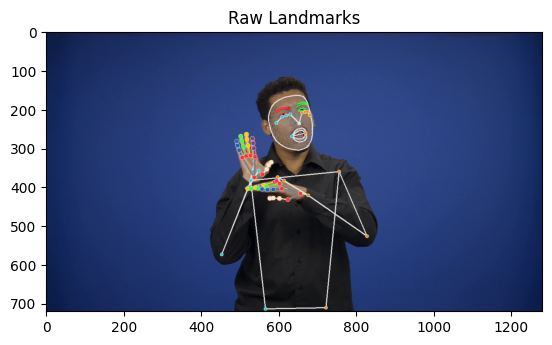

In [114]:
i = 20
video_path = os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "videos",
    metadata_row["filename"]
    )
landmarks = np.load(os.path.join(
    path_to_root,
    "data",
    "interim",
    "RawPoseLandmarks",
    'versionA', metadata_row["filename"].split(".")[0] + ".npy"
    ), allow_pickle=True)
frame = get_frame(i, video_path)
plot = mph.draw_landmarks_on_frame(frame, landmarks[i], )
plt.imshow(plot[:,:,::-1])
plt.title('Raw Landmarks')
plt.show()


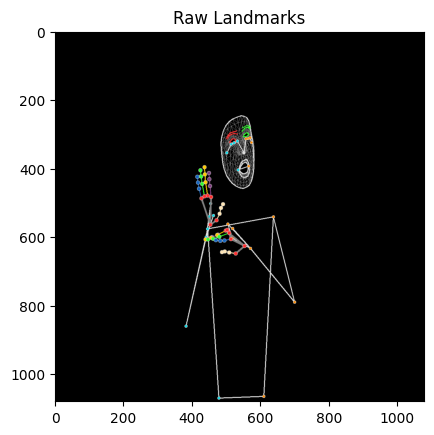

In [115]:
i = 20
video_path = os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "videos",
    metadata_row["filename"]
    )
landmarks = np.load(os.path.join(
    path_to_root,
    "data",
    "interim",
    "RawPoseLandmarks",
    'versionA', metadata_row["filename"].split(".")[0] + ".npy"
    ), allow_pickle=True)
plot = mph.draw_landmarks_on_frame(np.zeros((1080,1080,3), dtype=np.uint8), landmarks[i], )
plt.imshow(plot[:,:,::-1])
plt.title('Raw Landmarks')
plt.show()


### Processed



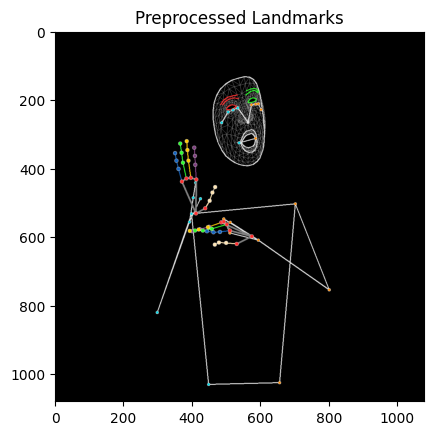

In [125]:
landmarks = np.load(os.path.join(
    path_to_root,
    "data",
    "preprocessed",
    "Landmarks",
    "v1",
    "landmarks",
    metadata_row["filename"].split(".")[0] + ".npy"
    ), allow_pickle=True)
plot = mph.draw_landmarks_on_frame(np.zeros((1080,1080,3), dtype=np.uint8), landmarks[i], )
plt.imshow(plot[:,:,::-1])
plt.title('Preprocessed Landmarks')
plt.show()
